In [2]:
import numpy as np
import pandas as pd
from scipy.fft import fft
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import euclidean
import matplotlib.pyplot as plt
#import seaborn as sns

In [ ]:
import pandas as pd
import numpy as np
from scipy.fft import fft, ifft
from scipy.spatial.distance import euclidean
import matplotlib.pyplot as plt

# Función para calcular el ciclo circadiano utilizando la Transformada de Fourier
def extract_circadian_cycle(data):
    fft_result = fft(data)
    n = len(data)
    freq = np.fft.fftfreq(n, d=1/24)
    
    # Filtrar para mantener solo frecuencias cercanas a 1 ciclo diario
    fft_filtered = fft_result.copy()
    fft_filtered[(freq < -1.8) | (freq > 1.8)] = 0
    
    # Reconstrucción de la señal para obtener el ciclo circadiano
    return np.real(ifft(fft_filtered))
    
def extract_circadian_cycle2(data, sample_rate=24, z=1):
    """
    Extrae el ciclo circadiano de una señal utilizando transformada de Fourier, 
    considerando únicamente los armónicos especificados por el rango z.

    Args:
        data (array): Señal de entrada.
        sample_rate (int): Tasa de muestreo (frecuencia en ciclos por día).
        z (int): Número de armónicos a considerar.

    Returns:
        array: Ciclo circadiano reconstruido.
    """
    fft_result = fft(data)
    n = len(data)
    freq = np.fft.fftfreq(n, d=1/sample_rate)
    
    # Mantener solo los armónicos en el rango [-z, z]
    fft_filtered = np.zeros_like(fft_result, dtype=complex)
    for k in range(-z, z + 1):
        idx = np.argmin(np.abs(freq - k))  # Encuentra el índice más cercano a la frecuencia k
        fft_filtered[idx] = fft_result[idx]
    
    # Reconstrucción de la señal para obtener el ciclo circadiano
    return np.real(ifft(fft_filtered))
 
# Configuración de datos de entrada
# Cargar los datos
nombres_csv = {1,2,3,4,468,479,4003,4151,4160,4173}
for nombre_csv in nombres_csv:
    df= pd.read_csv(f'Data2_actividad/{nombre_csv}_act.csv')
    df = df.copy()

    # Convertir 'Fecha' y 'Hora' a datetime e indexar el DataFrame
    df['datetime'] = pd.to_datetime(df['Fecha'] + ' ' + df['Hora'].astype(str) + ':00:00')
    df = df.set_index('datetime')
    df = df.sort_index()


    # Función para procesar una columna de actividad y calcular niveles de estrés
    def process_activity(df, activity_column):
        daily_cycles = {}
        
        # Extraer ciclo circadiano para cada día y almacenarlo
        for date, group in df.groupby(df.index.date):
            if len(group) == 24:  # Verificar 24 horas de datos
                daily_cycles[date] = extract_circadian_cycle2(group[activity_column].values)

        # Calcular el ciclo circadiano promedio
        average_cycle = np.mean(list(daily_cycles.values()), axis=0)

        # Calcular distancias entre el ciclo promedio y los ciclos diarios
        hourly_distances = []
        for date, cycle in daily_cycles.items():
            for hour in range(24):
                hourly_distances.append({
                    'Fecha': date,
                    'Hora': hour,
                    #'distancia': euclidean(average_cycle, cycle),
                    'distancia': np.absolute(average_cycle[hour]-cycle[hour])
                })

        distance_df = pd.DataFrame(hourly_distances)
        
        # Establecer umbrales de estrés usando desviación estándar
        mean_dist = distance_df['distancia'].mean()
        std_dist = distance_df['distancia'].std()
        threshold1 = mean_dist + std_dist
        threshold2 = mean_dist + 2 * std_dist
        

        # Clasificación de niveles de estrés basada en los umbrales
        def get_stress_level(distance):
            if distance <= threshold1:
                return 'normal'
            elif distance <= threshold2:
                return 'alerta'
            else:
                return 'peligro'

        # Aplicar la función de nivel de estrés a cada distancia
        distance_df['Nivel_estres'] = distance_df['distancia'].apply(get_stress_level)
        
        return distance_df[['Fecha', 'Hora', 'Nivel_estres']]

    # Procesar ambas columnas de actividad y calcular niveles de estrés
    stress_levels_1 = process_activity(df, 'activity_level').rename(columns={'Nivel_estres': 'Nivel_estres_1'})
    stress_levels_2 = process_activity(df, 'activity_level_2').rename(columns={'Nivel_estres': 'Nivel_estres_2'})

    # Fusionar niveles de estrés con el DataFrame original
    df['Fecha'] = pd.to_datetime(df['Fecha'])
    stress_levels_1['Fecha'] = pd.to_datetime(stress_levels_1['Fecha'])
    stress_levels_2['Fecha'] = pd.to_datetime(stress_levels_2['Fecha'])
    df['Hora'] = df['Hora'].astype(int)
    stress_levels_1['Hora'] = stress_levels_1['Hora'].astype(int)
    stress_levels_2['Hora'] = stress_levels_2['Hora'].astype(int)

    # Fusionar todos los DataFrames en df_final
    df_final = df.merge(stress_levels_1, on=['Fecha', 'Hora'], how='left')
    df_final = df_final.merge(stress_levels_2, on=['Fecha', 'Hora'], how='left')

    #df_final.to_csv(f'Datos_entrenamiento/{nombre_csv}_e.csv', index=False) 
    df_final.to_csv(f'Datos_prueba/{nombre_csv}_p.csv', index=False)   


In [19]:
import pandas as pd
import numpy as np
from scipy.fft import fft, ifft
from scipy.spatial.distance import euclidean
import matplotlib.pyplot as plt

daily_cycles = {}
# Configuración de datos de entrada
# Cargar los datos
nombres_csv = {4} #{1,2,3,4,468,479,4003,4151,4160,4173}
for nombre_csv in nombres_csv:
    df= pd.read_csv(f'../Data1_actividad/{nombre_csv}_act.csv')
    df = df.copy()

    # Convertir 'Fecha' y 'Hora' a datetime e indexar el DataFrame
    df['datetime'] = pd.to_datetime(df['Fecha'] + ' ' + df['Hora'].astype(str) + ':00:00')
    df = df.set_index('datetime')
    df = df.sort_index()

    # Función para calcular el ciclo circadiano utilizando la Transformada de Fourier
    def extract_circadian_cycle(data):
        fft_result = fft(data)
        n = len(data)
        freq = np.fft.fftfreq(n, d=1/24)
        
        # Filtrar para mantener solo frecuencias cercanas a 1 ciclo diario
        fft_filtered = fft_result.copy()
        fft_filtered[(freq < 0.8) | (freq > 1.2)] = 0
        
        # Reconstrucción de la señal para obtener el ciclo circadiano
        return np.real(ifft(fft_filtered))

    def extract_circadian_cycle2(data, sample_rate=24):
        # Eliminar tendencia
        detrended = data - data.mean()

        # FFT con ventana
        window = np.hanning(len(detrended))
        fft_result = fft(detrended * window)

        # Análisis espectral
        freq = np.fft.fftfreq(len(data), d=1/sample_rate)
        power = np.abs(fft_result)**2

        # Identificar frecuencia circadiana dominante
        daily_freq_mask = (freq >= 0.8) & (freq <= 1.2)
        if not np.any(daily_freq_mask):
            print("Advertencia: No se detectó ritmo circadiano claro")

        # Filtrado adaptativo
        fft_filtered = fft_result.copy()
        fft_filtered[~daily_freq_mask] *= 0.1  # Atenuar otras frecuencias

        return np.real(ifft(fft_filtered))
    
    # Función para procesar una columna de actividad y calcular niveles de estrés
    def process_activity(df, activity_column):
        
        
        # Extraer ciclo circadiano para cada día y almacenarlo
        for date, group in df.groupby(df.index.date):
            if len(group) == 24:  # Verificar 24 horas de datos
                daily_cycles[date] = extract_circadian_cycle(group[activity_column].values)

        # Calcular el ciclo circadiano promedio
        average_cycle = np.mean(list(daily_cycles.values()), axis=0)

        # Calcular distancias entre el ciclo promedio y los ciclos diarios
        hourly_distances = []
        for date, cycle in daily_cycles.items():
            for hour in range(24):
                hourly_distances.append({
                    'Fecha': date,
                    'Hora': hour,
                    'distancia': np.abs(average_cycle[hour]-cycle[hour])
                })

        distance_df = pd.DataFrame(hourly_distances)

        # Calcular umbrales para clasificar niveles de estrés
        # min_distance = distance_df['distancia'].min()
        # max_distance = distance_df['distancia'].max()
        # threshold1 = min_distance + (max_distance - min_distance) / 2
        # threshold2 = threshold1 + (max_distance - threshold1) / 2
        # threshold3 = max_distance
        
        # Establecer umbrales de estrés usando desviación estándar
        mean_dist = distance_df['distancia'].mean()
        std_dist = distance_df['distancia'].std()
        threshold1 = mean_dist + std_dist
        threshold2 = mean_dist + 2 * std_dist
        

        # Clasificación de niveles de estrés basada en los umbrales
        def get_stress_level(distance):
            if distance <= threshold1:
                return 'normal'
            elif distance <= threshold2:
                return 'alerta'
            else:
                return 'peligro'

        # Aplicar la función de nivel de estrés a cada distancia
        distance_df['Nivel_estres'] = distance_df['distancia'].apply(get_stress_level)
        
        return distance_df[['Fecha', 'Hora', 'Nivel_estres']]

    # Procesar ambas columnas de actividad y calcular niveles de estrés
    stress_levels_1 = process_activity(df, 'activity_level').rename(columns={'Nivel_estres': 'Nivel_estres_1'})
    stress_levels_2 = process_activity(df, 'activity_level_2').rename(columns={'Nivel_estres': 'Nivel_estres_2'})

    # Fusionar niveles de estrés con el DataFrame original
    df['Fecha'] = pd.to_datetime(df['Fecha'])
    stress_levels_1['Fecha'] = pd.to_datetime(stress_levels_1['Fecha'])
    stress_levels_2['Fecha'] = pd.to_datetime(stress_levels_2['Fecha'])
    df['Hora'] = df['Hora'].astype(int)
    stress_levels_1['Hora'] = stress_levels_1['Hora'].astype(int)
    stress_levels_2['Hora'] = stress_levels_2['Hora'].astype(int)

    # Fusionar todos los DataFrames en df_final
    df_final = df.merge(stress_levels_1, on=['Fecha', 'Hora'], how='left')
    df_final = df_final.merge(stress_levels_2, on=['Fecha', 'Hora'], how='left')

    #df_final.to_csv(f'Datos_entrenamiento/{nombre_csv}_e.csv', index=False) 
    #df_final.to_csv(f'Datos_prueba/{nombre_csv}_p.csv', index=False)   


In [20]:
df_final

,Fecha,Hora,period eating,period other,period resting,period rumination,period eating_count,period other_count,period resting_count,period rumination_count,activity_level,activity_level_2,Nivel_estres_1,Nivel_estres_2
0,2024-01-01,0,0.000,0.000,0.748,0.252,0.0,0.0,1.0,1.0,-0.270439,-0.425262,normal,normal
1,2024-01-01,1,0.118,0.000,0.662,0.220,1.0,0.0,1.0,1.0,-0.235627,-0.406524,normal,normal
2,2024-01-01,2,0.000,0.000,0.528,0.472,0.0,0.0,2.0,1.0,-0.280217,-0.553289,normal,normal
3,2024-01-01,3,0.000,0.000,0.777,0.223,0.0,0.0,1.0,1.0,-0.269150,-0.425262,normal,normal
4,2024-01-01,4,0.000,0.000,0.515,0.485,0.0,0.0,1.0,1.0,-0.280795,-0.425262,normal,normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3715,2024-06-30,19,0.000,0.082,0.446,0.472,0.0,1.0,2.0,1.0,-0.211146,0.554651,normal,normal
3716,2024-06-30,20,0.000,0.000,0.370,0.630,0.0,0.0,2.0,1.0,-0.287240,-0.553289,normal,normal
3717,2024-06-30,21,0.000,0.000,0.482,0.518,0.0,0.0,1.0,1.0,-0.282262,-0.425262,alerta,normal
3718,2024-06-30,22,0.000,0.000,0.511,0.489,0.0,0.0,1.0,2.0,-0.280973,-0.722495,alerta,normal


In [ ]:
nombre_csv=4
df= pd.read_csv(f'../Data1_actividad/{nombre_csv}_act.csv')
# Convertir 'Fecha' y 'Hora' a datetime
df['datetime'] = pd.to_datetime(df['Fecha'] + ' ' + df['Hora'].astype(str) + ':00:00')
df = df.set_index('datetime')
df = df.sort_index()

# Función para calcular la Transformada de Fourier y extraer el ciclo circadiano
def extract_circadian_cycle(data):
    fft_result = fft(data)
    n = len(data)
    freq = np.fft.fftfreq(n, d=1/24)
    
    # Filtrar frecuencias cercanas a 1 ciclo por día
    fft_filtered = fft_result.copy()
    fft_filtered[(freq < -1.8) | (freq > 1.8)] = 0
    
    # Reconstruir la señal
    return np.real(np.fft.ifft(fft_filtered))

# Calcular el ciclo circadiano para cada día en activity_level y activity_level_2
daily_cycles = {'activity_level': {}, 'activity_level_2': {}}
for date, group in df.groupby(df.index.date):
    if len(group) == 24:  # Asegurarse de que hay 24 horas de datos
        daily_cycles['activity_level'][date] = extract_circadian_cycle(group['activity_level'].values)
        daily_cycles['activity_level_2'][date] = extract_circadian_cycle(group['activity_level_2'].values)

# Calcular los ciclos circadianos promedio
average_cycle = {
    'activity_level': np.mean(list(daily_cycles['activity_level'].values()), axis=0),
    'activity_level_2': np.mean(list(daily_cycles['activity_level_2'].values()), axis=0)
}

# Calcular la distancia absoluta entre cada hora del ciclo promedio y cada día
hourly_distances = []
for date, cycle1 in daily_cycles['activity_level'].items():
    cycle2 = daily_cycles['activity_level_2'][date]
    for hour in range(24):
        
        #Calcula las diferencias al cuadrado para ambos niveles
        diff_activity_level = euclidean(average_cycle['activity_level'],cycle1)
        diff_activity_level_2 = euclidean(average_cycle['activity_level_2'], cycle2)
        
        # Calcula la distancia euclidiana como la raíz cuadrada de la suma de las diferencias al cuadrado
        #euclidean_distance = (diff_activity_level + diff_activity_level_2) ** 0.5
        
        hourly_distances.append({
            'Fecha': date,
            'Hora': hour,
            'distancia_activity_level': diff_activity_level,
            'distancia_activity_level_2': diff_activity_level_2,
        })

# Convertir las distancias horarias a un DataFrame
distance_df = pd.DataFrame(hourly_distances)

# # Calcular los umbrales para los niveles de estrés
# min_distance_1 = distance_df['distancia_activity_level'].min()
# max_distance_1 = distance_df['distancia_activity_level'].max()
# threshold1_1 = min_distance_1+ (max_distance_1 - min_distance_1) / 2
# threshold2_1 = threshold1_1 + (max_distance_1 - threshold1_1) /2
# threshold3_1 = max_distance_1

# min_distance_2 = distance_df['distancia_activity_level_2'].min()
# max_distance_2 = distance_df['distancia_activity_level_2'].max()
# threshold1_2 = min_distance_2 + (max_distance_2 - min_distance_2) / 2
# threshold2_2 = threshold1_2 + (max_distance_2 - threshold1_2) /2
# threshold3_2 = max_distance_2

mean_dist_1 = distance_df['distancia_activity_level'].mean()
std_dist_1 = distance_df['distancia_activity_level'].std()
threshold1_1 = mean_dist_1 + std_dist_1
threshold2_1 = mean_dist_1 + 2 * std_dist_1

mean_dist_2 = distance_df['distancia_activity_level_2'].mean()
std_dist_2 = distance_df['distancia_activity_level_2'].std()
threshold1_2 = mean_dist_2 + std_dist_2
threshold2_2 = mean_dist_2 + 2 * std_dist_2

# Función para determinar el nivel de estrés
def get_stress_level(distance, threshold1, threshold2):
    if distance <= threshold1:
        return 'normal'
    elif distance <= threshold2:
        return 'alerta'
    else:
        return 'peligro'

# Aplicar la función a las distancias y crear columnas de niveles de estrés
distance_df['stress_level'] = distance_df['distancia_activity_level'].apply(lambda x: get_stress_level(x, threshold1_1, threshold2_1))
distance_df['stress_level_2'] = distance_df['distancia_activity_level_2'].apply(lambda x: get_stress_level(x, threshold1_2, threshold2_2))

# Convertir fechas en ambos DataFrames para combinar
df['Fecha'] = pd.to_datetime(df['Fecha'])
distance_df['Fecha'] = pd.to_datetime(distance_df['Fecha'])
df['Hora'] = df['Hora'].astype(int)
distance_df['Hora'] = distance_df['Hora'].astype(int)

# Combinar el DataFrame original con los niveles de estrés
df = df.merge(distance_df[['Fecha', 'Hora', 'stress_level', 'stress_level_2']], on=['Fecha', 'Hora'], how='left')

df


,Fecha,Hora,period eating,period other,period resting,period rumination,period eating_count,period other_count,period resting_count,period rumination_count,activity_level,activity_level_2,stress_level,stress_level_2
0,2024-01-01,0,0.000,0.000,0.748,0.252,0.0,0.0,1.0,1.0,-0.270439,-0.425262,normal,normal
1,2024-01-01,1,0.118,0.000,0.662,0.220,1.0,0.0,1.0,1.0,-0.235627,-0.406524,normal,normal
2,2024-01-01,2,0.000,0.000,0.528,0.472,0.0,0.0,2.0,1.0,-0.280217,-0.553289,normal,normal
3,2024-01-01,3,0.000,0.000,0.777,0.223,0.0,0.0,1.0,1.0,-0.269150,-0.425262,normal,normal
4,2024-01-01,4,0.000,0.000,0.515,0.485,0.0,0.0,1.0,1.0,-0.280795,-0.425262,normal,normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3715,2024-06-30,19,0.000,0.082,0.446,0.472,0.0,1.0,2.0,1.0,-0.211146,0.554651,normal,normal
3716,2024-06-30,20,0.000,0.000,0.370,0.630,0.0,0.0,2.0,1.0,-0.287240,-0.553289,normal,normal
3717,2024-06-30,21,0.000,0.000,0.482,0.518,0.0,0.0,1.0,1.0,-0.282262,-0.425262,normal,normal
3718,2024-06-30,22,0.000,0.000,0.511,0.489,0.0,0.0,1.0,2.0,-0.280973,-0.722495,normal,normal


C:\Users\PC\AppData\Local\Temp\ipykernel_17796\800675728.py:20: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


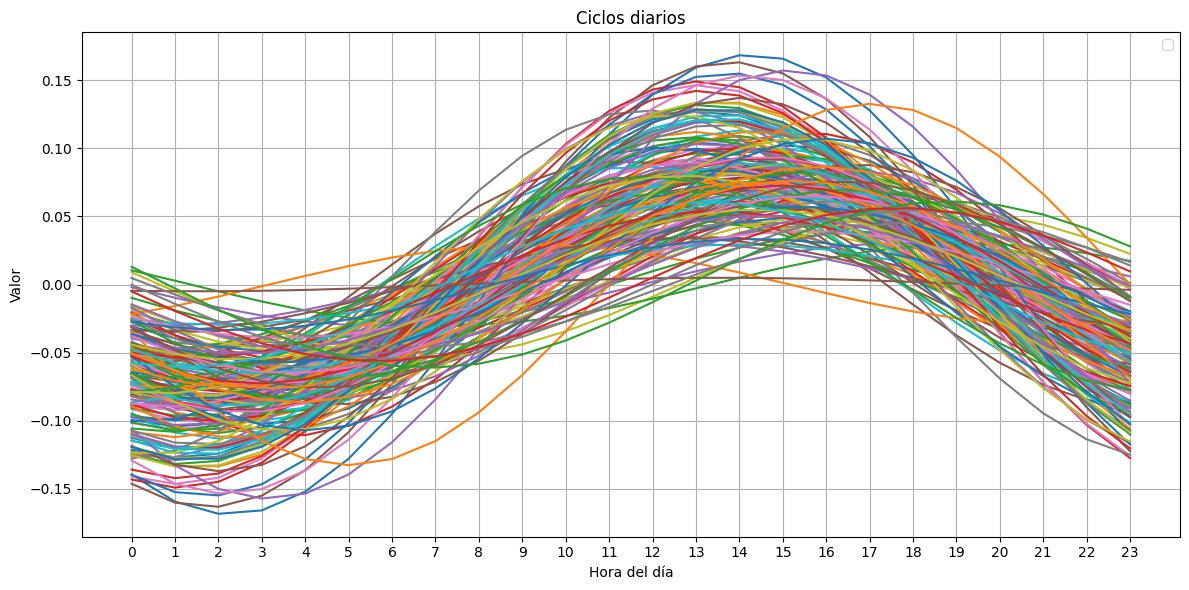

In [33]:
# Asumiendo que ya tienes tu diccionario daily_cycles

# Crear la figura y los ejes
fig, ax = plt.subplots(figsize=(12, 6))

# Graficar cada día
for date, values in daily_cycles['activity_level'].items():
    ax.plot(range(24), values)

# Configurar el eje x
ax.set_xticks(range(24))
ax.set_xticklabels(range(24))
ax.set_xlabel('Hora del día')

# Configurar el eje y
ax.set_ylabel('Valor')

# Añadir título y leyenda
ax.set_title('Ciclos diarios')
ax.legend()

# Mostrar la gráfica
plt.grid(True)
plt.tight_layout()
#plt.savefig(f'../Ciclos circadianos/{nombre_csv}_diario.png', format='png', dpi=300)
plt.show()

C:\Users\PC\AppData\Local\Temp\ipykernel_17796\4151329720.py:7: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hours = pd.date_range(start=date, periods=24, freq='H')


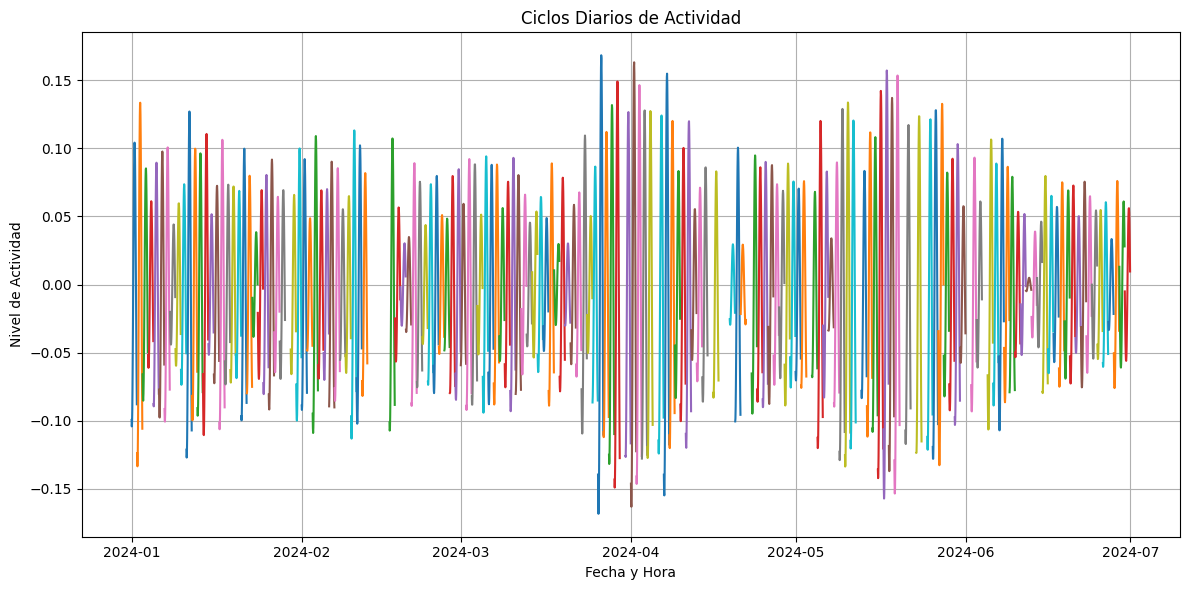

In [34]:
# Crear la figura y los ejes
plt.figure(figsize=(12, 6))

# Graficar cada día como una serie continua con la fecha en el eje x
for date, values in daily_cycles['activity_level'].items():
    # Crear un índice de fechas para cada hora del día de ese día específico
    hours = pd.date_range(start=date, periods=24, freq='H')
    plt.plot(hours, values, label=str(date))

# Configuración del gráfico
plt.title('Ciclos Diarios de Actividad')
plt.xlabel('Fecha y Hora')
plt.ylabel('Nivel de Actividad')
# plt.legend(title='Día', loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(True)
plt.tight_layout()

# Mostrar la gráfica
plt.show()


C:\Users\PC\AppData\Local\Temp\ipykernel_17796\1382436481.py:7: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hours = pd.date_range(start=date, periods=24, freq='H')


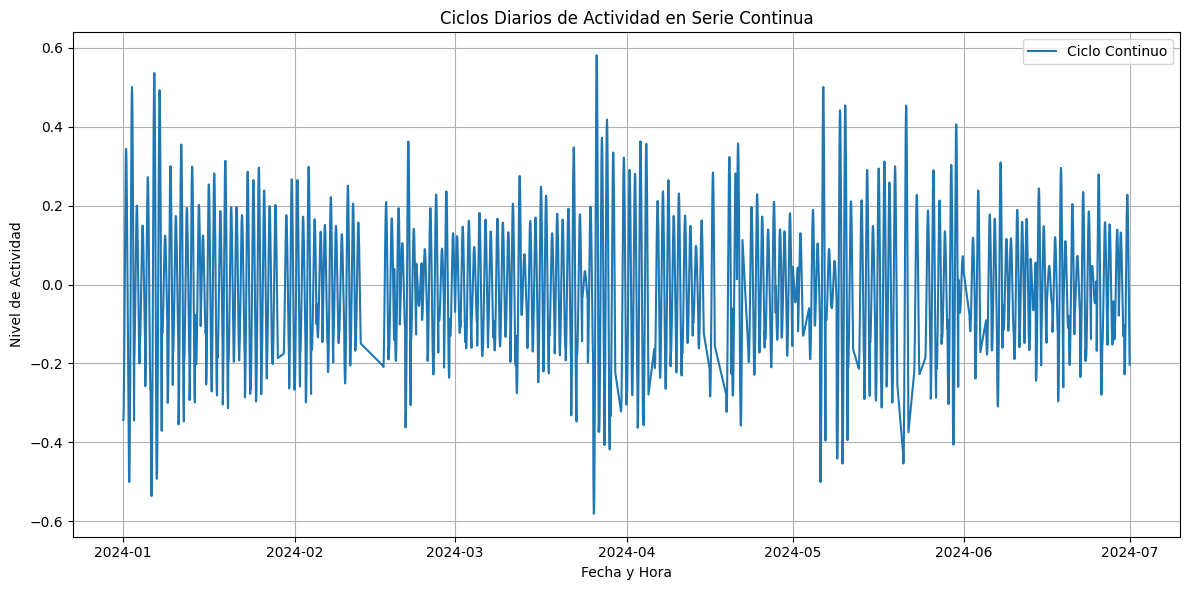

In [35]:
# Crear una lista para almacenar los DataFrames de cada ciclo diario
cycles_list = []

# Convertir cada ciclo diario en un DataFrame con índice de fecha-hora y agregarlo a la lista
for date, values in daily_cycles['activity_level_2'].items():
    # Crear un índice de fechas para cada hora del día
    hours = pd.date_range(start=date, periods=24, freq='H')
    df_daily = pd.DataFrame({'activity_level_2': values}, index=hours)
    cycles_list.append(df_daily)

# Concatenar todos los DataFrames en uno solo para crear una serie continua
df_continuous = pd.concat(cycles_list)

# Graficar la serie continua
plt.figure(figsize=(12, 6))
plt.plot(df_continuous.index, df_continuous['activity_level_2'], label='Ciclo Continuo')
plt.title('Ciclos Diarios de Actividad en Serie Continua')
plt.xlabel('Fecha y Hora')
plt.ylabel('Nivel de Actividad')
plt.legend()
plt.grid(True)
plt.tight_layout()

# Mostrar la gráfica
plt.show()


In [36]:
average_cycle['activity_level']

array([-0.06677612, -0.07530363, -0.07869933, -0.07673179, -0.06953512,
       -0.05759973, -0.04173902, -0.02303387, -0.002759  ,  0.0177039 ,
        0.0369603 ,  0.05369792,  0.06677612,  0.07530363,  0.07869933,
        0.07673179,  0.06953512,  0.05759973,  0.04173902,  0.02303387,
        0.002759  , -0.0177039 , -0.0369603 , -0.05369792])

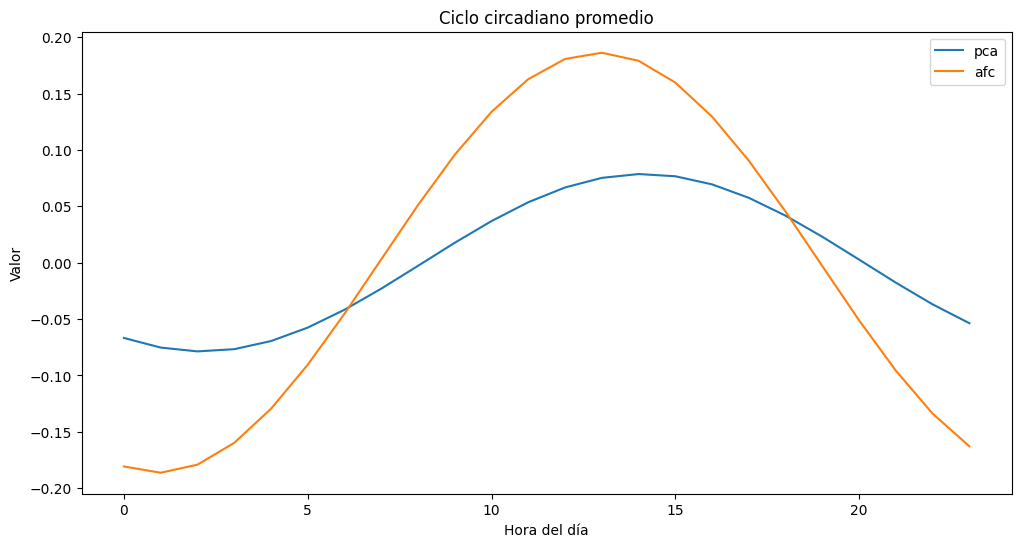

In [39]:
# Crear la gráfica de líneas
plt.figure(figsize=(12, 6))
plt.plot(average_cycle['activity_level'], label='pca')
plt.plot(average_cycle['activity_level_2'], label='afc')
plt.title('Ciclo circadiano promedio')
plt.xlabel('Hora del día')
plt.ylabel('Valor')
plt.legend()
#plt.savefig(f'../Ciclos circadianos/{nombre_csv}_promedio.png', format='png', dpi=300)
plt.show()

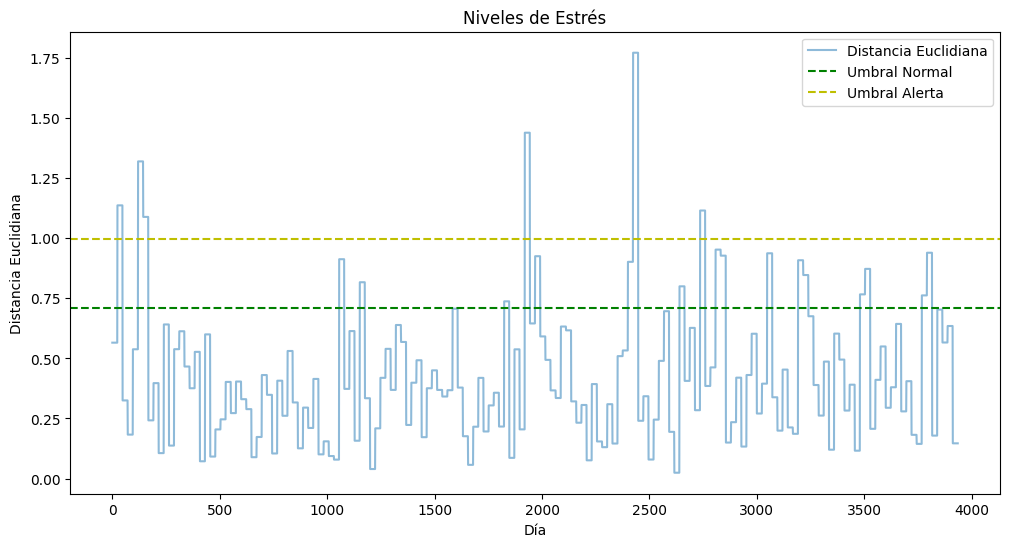

In [42]:
# Crear la gráfica de líneas
plt.figure(figsize=(12, 6))
#plt.plot(distance_df['distancia_activity_level'], label='Distancia Euclidiana')
#sns.histplot(distance_df['distancia_activity_level_2'], kde=True)
plt.plot(distance_df['distancia_activity_level_2'], label='Distancia Euclidiana', alpha=0.5)
plt.axhline(y=threshold1_2, color='g', linestyle='--', label='Umbral Normal')
plt.axhline(y=threshold2_2, color='y', linestyle='--', label='Umbral Alerta')
#plt.axhline(y=threshold3_2, color='r', linestyle='--', label='Umbral Peligro')
plt.title('Niveles de Estrés')
plt.xlabel('Día')
plt.ylabel('Distancia Euclidiana')
plt.legend()
plt.show()

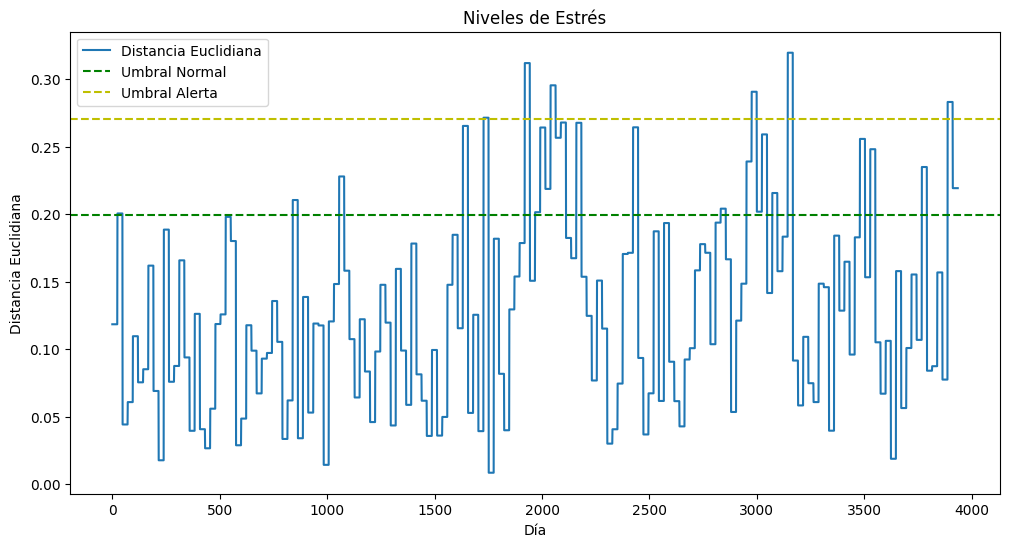

In [41]:
# Crear la gráfica de líneas
plt.figure(figsize=(12, 6))
plt.plot(distance_df['distancia_activity_level'], label='Distancia Euclidiana')
#plt.plot(distance_df['distancia_activity_level_2'], label='Distancia Euclidiana')
plt.axhline(y=threshold1_1, color='g', linestyle='--', label='Umbral Normal')
plt.axhline(y=threshold2_1, color='y', linestyle='--', label='Umbral Alerta')
#plt.axhline(y=threshold3_1, color='r', linestyle='--', label='Umbral Peligro')
plt.title('Niveles de Estrés')
plt.xlabel('Día')
plt.ylabel('Distancia Euclidiana')
plt.legend()
plt.show()

In [ ]:
# Contar los niveles de estrés


print(df['stress_level'].value_counts())

stress_level
normal     2784
alerta      792
peligro     360
Name: count, dtype: int64


In [ ]:
# Contar los niveles de estrés
print(df['stress_level_2'].value_counts())

stress_level_2
normal     3600
alerta      288
peligro      48
Name: count, dtype: int64
